# Classification: images

## Contents

- [1. Preliminary](#1-preliminary)
    - [1.1 Imports](#1-1-import)
    - [1.2 Initial data preparations](#1-2-init)
- [2. Common orthogonal basis extraction (COBE)](#2-cobe)
    - [2.1 Initialization](#2-1-init)
    - [2.2 Learning](#2-2-learning)
    - [2.3 Prediction](#2-3-prediction)
    - [2.4 Results](#2-4-results)
- [3. Group independent component analysis (GICA)](#3-gica)
    - [3.1 Initialization](#3-1-init)
    - [3.2 Learning](#3-2-learning)
    - [3.3 Prediction](#3-3-prediction)
    - [3.4 Results](#3-4-results)
- [4. Group (Lr, 1) decomposition (GLRO)](#4-glro)
    - [4.1 Initialization](#4-1-init)
    - [4.2 Learning](#4-2-learning)
    - [4.3 Prediction](#4-3-prediction)
    - [4.4 Results](#4-4-results)
- [5. Group Tucker-(Lr, 1) decomposition (GTLD)](#5-gtld)
    - [5.1 Initialization](#5-1-init)
    - [5.2 Learning](#5-2-learning)
    - [5.3 Prediction](#5-3-prediction)
    - [5.4 Results](#5-4-results)


## 1. Preliminary <a class="anchor" id="1-preliminary"></a>
    
- [1.1 Imports](#1-1-import)
- [1.2 Initial data preparations](#1-2-init)


[Back to contents](#Contents)

### 1.1 Imports <a class="anchor" id="1-1-import"></a>

[Up to section](#1-preliminary) $\quad$
[Back to contents](#Contents)

In [1]:
import sys
sys.path.append('../')
import os
import copy

import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from src.computational_utilities import reshape
from src.classifiers import COBEClassifier, GICAClassifier, GLROClassifier, GTLDClassifier

import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Initial data preparations <a class="anchor" id="1-2-init"></a>

[Up to section](#1-preliminary) $\quad$
[Back to contents](#Contents)

In [2]:
data_dirname = '../../data/'
data_filename = 'eth80_128.npz'

df = np.load(data_dirname+data_filename)

data, labels = df['data'], df['classes']
labels = labels.tolist()
Nclasses, Nobjects, Nframes, Npix1, Npix2, Ncolors = data.shape
Npix = Npix1*Npix2
Nsamples = Nclasses*Nobjects
labels = labels*Nobjects

new_shape = [-1, Nframes, Npix, Ncolors]
data = reshape(data, new_shape)

classEncoder = LabelEncoder()
classEncoder.fit(labels)
y = classEncoder.transform(labels)
#classEncoder.inverse_transform(y)

random_state = 235
n_splits = 4
n_repeats = 1
separator = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

dummyX = np.empty(Nsamples)
train_indices, test_indices = [], []
for train_index, test_index in separator.split(dummyX, y):
    train_indices.append(train_index)
    test_indices.append(test_index)
    
metrics = [
    accuracy_score,
    lambda x, y: precision_score(x, y, average='macro'),
    lambda x, y: recall_score(x, y, average='macro'),
    lambda x, y: f1_score(x, y, average='macro')
]

## 2. Common orthogonal basis extraction (COBE) <a class="anchor" id="2-cobe"></a>

- [2.1 Initialization](#2-1-init)
- [2.2 Learning](#2-2-learning)
- [2.3 Prediction](#2-3-prediction)
- [2.4 Results](#2-4-results)

[Back to contents](#Contents)

### 2.1 Initialization <a class="anchor" id="2-1-init"></a>

Two variants of decomposition are possible: either joining colors and pixels as one source mode (highest results but joint source feature space) or joining colors and frames (lower results, but isolated pixel mode)

[Up to section](#2-cobe) $\quad$
[Back to contents](#Contents)

In [11]:
print 'isolated pixel mode for source extraction: X1'
shapeCOBE1 = [Nsamples, Npix, Nframes*Ncolors] #####
X1 = np.transpose(data, [0, 2, 1, 3])
X1 = reshape(X1, shapeCOBE1)
print 'joint pixel and color mode for source extraction: X2'
shapeCOBE2 = [Nsamples, Npix*Ncolors, Nframes]
X2 = np.transpose(data, [0, 2, 3, 1])
X2 = reshape(X2, shapeCOBE2)

variants = {
    'isolated': X1,
    'joint': X2
}

commonRanks = 1+np.arange(10)
maxitnum = 50
epsilon = 1e-5

random_State = None
model_dirname = '../models/cobe/'

isolated pixel mode for source extraction: X1
joint pixel and color mode for source extraction: X2


### 2.2 Learning <a class="anchor" id="2-2-learning"></a>

[Up to section](#2-cobe) $\quad$
[Back to contents](#Contents)

In [ ]:
try:
    os.makedirs(model_dirname)
except:
    print 'Already exist: %s' % (model_dirname)
    
keyword_variants = variants.keys()
# estimate parameters
for k_variant in xrange(len(keyword_variants)):
    keyword = keyword_variants[k_variant]
    X = variants[keyword]
    shapeCOBE = X.shape
    for i in xrange(len(commonRanks)):
        commonRank = commonRanks[i]
        print "Rank %d (%3.2f%%)" % (commonRank, float(i+1)/len(commonRanks) * 100.)
        for j in xrange(len(train_indices)):
            train_index = train_indices[j]

            classifier = COBEClassifier(commonRank, shapeCOBE[1:], maxitnum, epsilon)
            classifier.fit(X[train_index], y[train_index])
            save_filename_base = '%s_COBE_rank=%d_%d' % (keyword, commonRank, j)
            classifier.saveParameters(model_dirname+'unconstrained_'+save_filename_base)
            classifier.transformSources('ica', random_state, maxitnum)
            classifier.saveParameters(model_dirname+'ica_'+save_filename_base)
            print "\t Index %d / %d" % (j+1, len(train_indices))

### 2.3 Prediction <a class="anchor" id="2-3-prediction"></a>

[Up to section](#2-cobe) $\quad$
[Back to contents](#Contents)

In [35]:
result_dirname = '../results/experiment2/'
result_filename = 'COBE_eth80_128.npz'

try:
    os.makedirs(result_dirname)
except:
    print 'Already exist: %s' % (result_dirname)

prefixes = ['unconstrained', 'ica']
results = np.zeros([len(variants), len(commonRanks), n_splits, len(prefixes), len(metrics)])
keyword_variants = variants.keys()
for k_variant in xrange(len(variants)):
    keyword = keyword_variants[k_variant]
    X = variants[keyword]
    shapeCOBE = X.shape
    for k_comr in xrange(len(commonRanks)):
        commonRank = commonRanks[k_comr]
        for k_trial in xrange(n_splits):
            model_filename_base = 'COBE_rank=%d_%d' % (commonRank, k_trial)
            for k_pref in xrange(len(prefixes)):
                prefix = '%s_%s_'% (prefixes[k_pref], keyword)
                classifier = COBEClassifier(commonRank, shapeCOBE[1:], maxitnum, epsilon)
                classifier.loadParameters(model_dirname+prefix+model_filename_base+'.npz')
                y_true = y[test_indices[k_trial]]
                y_pred = classifier.predict(X[test_indices[k_trial]])
                for k_metric in xrange(len(metrics)):
                    results[k_variant, k_comr, k_trial, k_pref, k_metric] = metrics[k_metric](y_true, y_pred)
np.savez_compressed(result_dirname+result_filename, results=results)

Already exist: ../results/experiment2/


### 2.4 Results <a class="anchor" id="2-4-results"></a>

[Up to section](#2-cobe) $\quad$
[Back to contents](#Contents)

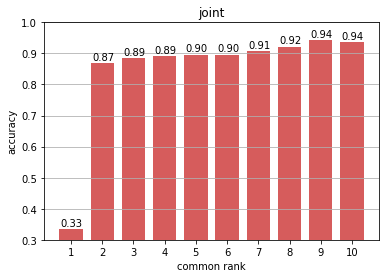

Common rank = 9, source mode = joint
Accuracy  Precision  Recall  F1 score
[0.94270833 0.95833333 0.94270833 0.94047619]


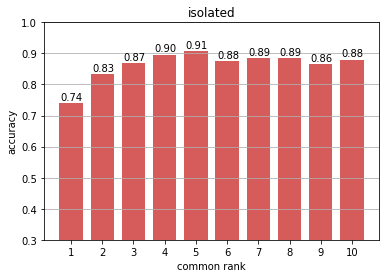

Common rank = 5, source mode = isolated
Accuracy  Precision  Recall  F1 score
[0.90625    0.92447917 0.90625    0.90238095]


In [40]:
result_dirname = '../results/experiment2/'
result_filename = 'COBE_eth80_128.npz'

df = np.load(result_dirname+result_filename)

a = np.mean(df['results'], axis=2)[:, :, 1, :] # select ica
commonRanks = 1+np.arange(a.shape[1])
commonRankTicks = map(lambda x: '%d' % (x), commonRanks)

keyword_variants = variants.keys()
for k_variant in xrange(len(variants)):
    keyword = keyword_variants[k_variant]
    f, ax = plt.subplots(figsize=(6, 4))
    barwidth = 0.75

    barplot_palette = ['#CC3333']

    b1a = ax.bar(
        commonRanks, a[k_variant, :, 0], width=barwidth, color=barplot_palette[0], alpha=0.8
    )



    for i in xrange(a.shape[1]):
        xcord = commonRanks[i]-0.325
        ycord = a[k_variant, i, 0]+0.01
        ax.text(xcord, ycord, '%.2f' % (a[k_variant, i, 0]))

    ax.set_ylim(0.3, 1.0)
    ax.set_xticks(commonRanks)
    ax.set_xticklabels(commonRankTicks)
    ax.set_xlabel('common rank')
    ax.set_ylabel('accuracy')
    ax.yaxis.grid(True)
    plt.title(keyword_variants[k_variant])
    plt.show()


    ind = np.where(a[k_variant, :, 0] == a[k_variant, :, 0].max())[0]

    print "Common rank = %d, source mode = %s" % (commonRanks[ind[0]], keyword)
    print "Accuracy  Precision  Recall  F1 score"
    print a[k_variant, ind[0], :]

## 3. Group independent component analysis (GICA) <a class="anchor" id="3-gica"></a>

- [3.1 Initialization](#3-1-init)
- [3.2 Learning](#3-2-learning)
- [3.3 Prediction](#3-3-prediction)
- [3.4 Results](#3-4-results)

[Back to contents](#Contents)

### 3.1 Initialization <a class="anchor" id="3-1-init"></a>

Two variants of decomposition are possible: either joining colors and pixels as one source mode (highest results but joint source feature space) or joining colors and frames (lower results, but isolated pixel mode)


[Up to section](#3-gica) $\quad$
[Back to contents](#Contents)

In [44]:
print 'isolated pixel mode for source extraction: X1'
shapeGICA1 = [Nsamples, Npix, Nframes*Ncolors] #####
X1 = np.transpose(data, [0, 2, 1, 3])
X1 = reshape(X1, shapeGICA1)
print 'joint pixel and color mode for source extraction: X2'
shapeGICA2 = [Nsamples, Npix*Ncolors, Nframes]
X2 = np.transpose(data, [0, 2, 3, 1])
X2 = reshape(X2, shapeGICA2)

variants = {
    'isolated': X1,
    'joint': X2
}

individualRanks = 1+np.arange(10)
commonRanks = 1+np.arange(10)
maxitnum = 50
epsilon = 1e-5

random_State = None
model_dirname = '../models/gica/'


isolated pixel mode for source extraction: X1
joint pixel and color mode for source extraction: X2


### 3.2 Learning <a class="anchor" id="3-2-learning"></a>

[Up to section](#3-gica) $\quad$
[Back to contents](#Contents)

In [ ]:
try:
    os.makedirs(model_dirname)
except:
    print 'Already exist: %s' % (model_dirname)

keyword_variants = variants.keys()
# estimate parameters
for k_variant in xrange(len(keyword_variants)):
    keyword = keyword_variants[k_variant]
    X = variants[keyword]
    shapeGICA = X.shape
    for k_comr in xrange(len(commonRanks)):
        commonRank = commonRanks[k_comr]
        print "Rank %d (%3.2f%%)" % (commonRank, float(k_comr+1)/len(commonRanks) * 100.)
        for k_indr in xrange(len(individualRanks)):
            individualRank = individualRanks[k_indr]
            print "\t Rank %d (%3.2f%%)" % (individualRank, float(k_indr+1)/len(individualRanks) * 100.)
            for k_trial in xrange(len(train_indices)):
                train_index = train_indices[k_trial]
                classifier = GICAClassifier(
                    individualRank, commonRank, commonRank, shapeGICA[1:],
                    maxitnum, epsilon
                )

                classifier.fit(X[train_index], y[train_index])
                save_filename_base = '%s_GICA_crank=%d_irank=%d_%d' % (
                    keyword, commonRank, individualRank, k_trial
                )
                classifier.saveParameters(model_dirname+save_filename_base)
                print "\t\t Index %d / %d" % (k_trial+1, len(train_indices))

### 3.3 Prediction <a class="anchor" id="3-3-prediction"></a>

[Up to section](#3-gica) $\quad$
[Back to contents](#Contents)

In [51]:
result_dirname = '../results/experiment2/'
result_filename = 'GICA_eth80_128.npz'

try:
    os.makedirs(result_dirname)
except:
    print 'Already exist: %s' % (result_dirname)

results = np.zeros([len(variants), len(commonRanks), len(individualRanks), n_splits, len(metrics)])
keyword_variants = variants.keys()
for k_variant in xrange(len(variants)):
    keyword = keyword_variants[k_variant]
    X = variants[keyword]
    shapeGICA = X.shape
    for k_comr in xrange(len(commonRanks)):
        commonRank = commonRanks[k_comr]
        for k_indr in xrange(len(individualRanks)):
            individualRank = individualRanks[k_indr]
            for k_trial in xrange(n_splits):
                model_filename_base = '%s_GICA_crank=%d_irank=%d_%d' % (
                    keyword, commonRank, individualRank, k_trial
                )
                classifier = GICAClassifier(
                    individualRank, commonRank, commonRank, shapeGICA[1:], maxitnum, epsilon
                )
                classifier.loadParameters(model_dirname+model_filename_base+'.npz')
                y_true = y[test_indices[k_trial]]
                y_pred = classifier.predict(X[test_indices[k_trial]])
                for k_metric in xrange(len(metrics)):
                    results[k_variant, k_comr, k_indr, k_trial, k_metric] = metrics[k_metric](y_true, y_pred)
        
np.savez_compressed(result_dirname+result_filename, results=results)

Already exist: ../results/experiment2/


### 3.4 Results <a class="anchor" id="3-4-results"></a>

[Up to section](#3-gica) $\quad$
[Back to contents](#Contents)

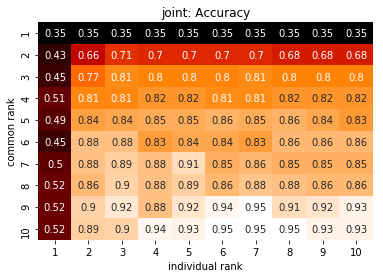

Source mode = joint, Common rank = 9, Individual rank = 7
Accuracy  Precision  Recall  F1 score
[0.94791667 0.96354167 0.94791667 0.9452381 ]


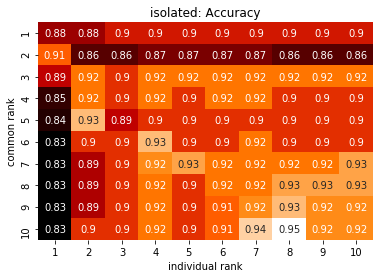

Source mode = isolated, Common rank = 10, Individual rank = 8
Accuracy  Precision  Recall  F1 score
[0.94791667 0.96354167 0.94791667 0.9452381 ]


In [52]:
result_dirname = '../results/experiment2/'
result_filename = 'GICA_eth80_128.npz'

df = np.load(result_dirname+result_filename)

a = np.mean(df['results'], axis=3)
individualRanks = 1+np.arange(a.shape[2])
commonRanks = 1+np.arange(a.shape[1])
cmapHot = plt.get_cmap('gist_heat')

keyword_variants = variants.keys()
for k_variant in xrange(len(variants)):
    keyword = keyword_variants[k_variant]

    ax = sns.heatmap(
        a[k_variant, :, :, 0], annot=True, cmap=cmapHot, cbar=False,
        xticklabels=individualRanks, yticklabels=commonRanks
    )
    ax.set_xlabel('individual rank')
    ax.set_ylabel('common rank')
    plt.title('%s: Accuracy' % (keyword))
    plt.show()

    ind = np.where(a[k_variant, :, :, 0] == a[k_variant, :, :, 0].max())

    print "Source mode = %s, Common rank = %d, Individual rank = %d" % (
        keyword, commonRanks[ind[0][0]], individualRanks[ind[1][0]]
    )
    print "Accuracy  Precision  Recall  F1 score"
    print a[k_variant, ind[0][0], ind[1][0], :]

## 4. Group (Lr, 1) decomposition (GLRO) <a class="anchor" id="4-glro"></a>

- [4.1 Initialization](#4-1-init)
- [4.2 Learning](#4-2-learning)
- [4.3 Prediction](#4-3-prediction)
- [4.4 Results](#4-4-results)

[Back to contents](#Contents)

### 4.1 Initialization <a class="anchor" id="4-1-init"></a>

[Up to section](#4-glro) $\quad$
[Back to contents](#Contents)

In [53]:
shapeGLRO = [Nsamples, Nframes, Npix, Ncolors]
X = reshape(data, shapeGLRO)
transposition = [0, 2, 1, 3]
X = np.transpose(X, transposition)
shapeGLRO = X.shape

method_name = 'als'
constraint_method = 'projected'

individualRanks = 1+np.arange(10)
commonRanks = 1+np.arange(10)
maxitnum = 10
epsilon = 1e-5

sourceModes = [0] # Nsamples are not to be taken into account

random_State = None
model_dirname = '../models/glro/'

### 4.2 Learning <a class="anchor" id="4-2-learning"></a>

[Up to section](#4-glro) $\quad$
[Back to contents](#Contents)

In [ ]:
method_name = 'als'
maxitnum = 10
sourceModes = [0]

try:
    os.makedirs(model_dirname)
except:
    print 'Already exist: %s' % (model_dirname)

# estimate parameters
for k_comr in xrange(len(commonRanks)):
    commonRank = commonRanks[k_comr]
    print "Rank %d (%3.2f%%)" % (commonRank, float(k_comr+1)/len(commonRanks) * 100.)
    for k_indr in xrange(len(individualRanks)):
        individualRank = individualRanks[k_indr]
        print "\t Rank %d (%3.2f%%)" % (individualRank, float(k_indr+1)/len(individualRanks) * 100.)
        for k_trial in xrange(len(train_indices)):
            train_index = train_indices[k_trial]
            classifier = GLROClassifier(
                individualRank, commonRank, shapeGLRO[1:], sourceModes, method=method_name, nShortModes=None,
                constraintMethod=constraint_method, fullModesConstraint=None, maxitnum=maxitnum,
                epsilon=epsilon
            )
            
            classifier.fit(X[train_index], y[train_index], verbose=1)
            save_filename_base = 'GLRO_crank=%d_irank=%d_%d' % (commonRank, individualRank, k_trial)
            classifier.saveParameters(model_dirname+'unconstrained_'+save_filename_base)
            classifier.transformSources('ica', random_state, maxitnum)
            classifier.saveParameters(model_dirname+'ica_'+save_filename_base)
            print "\t\t Index %d / %d" % (k_trial+1, len(train_indices))

### 4.3 Prediction <a class="anchor" id="4-3-prediction"></a>

[Up to section](#4-glro) $\quad$
[Back to contents](#Contents)

In [ ]:
method_name = 'als'
# method_name = 'dogleg'
# method_name = 'scg-fn'

prefixes = ['unconstrained', 'ica']
results = np.zeros([len(commonRanks), len(individualRanks), n_splits, len(prefixes), len(metrics)])

model_dirname = '../models/glro/'
save_dirname = '../results/experiment2/'

try:
    os.makedirs(save_dirname)
except:
    print 'Already exist: %s' % (save_dirname)
    
for k_pref in xrange(len(prefixes)):
    prefix = prefixes[k_pref]
    print prefix
    for k_comr in xrange(len(commonRanks)):
        commonRank = commonRanks[k_comr]
        print "Rank %d (%3.2f%%)" % (commonRank, float(k_comr+1)/len(commonRanks) * 100.)
        for k_indr in xrange(len(individualRanks)):
            individualRank = individualRanks[k_indr]
            print "\t Rank %d (%3.2f%%)" % (individualRank, float(k_indr+1)/len(individualRanks) * 100.)
            for k_trial in xrange(n_splits):
                print k_trial, n_splits
                model_filename_base = 'GLRO_crank=%d_irank=%d_%d' % (commonRank, individualRank, k_trial)
                classifier = GLROClassifier(
                    individualRank, commonRank, shapeGLRO[1:], sourceModes,
                    method=method_name, nShortModes=None,
                    constraintMethod='projected', fullModesConstraint=None
                )
                classifier.loadParameters(model_dirname+prefix+'_'+model_filename_base+'.npz')
                y_true = y[test_indices[k_trial]]

                y_pred = classifier.predict(
                    X[test_indices[k_trial]],
                    reproject=0,
                )
                for k_metric in xrange(len(metrics)):
                    results[k_comr, k_indr, k_trial, k_pref, k_metric] = metrics[k_metric](y_true, y_pred)
                np.savez_compressed(
                    save_dirname+method_name+'_GLRO_eth80_128',
                    results=results, method_name=method_name,
                    prefixes=prefixes, commonRanks=commonRanks,
                    individualRanks=individualRanks, n_splits=n_splits
                )

### 4.4 Results <a class="anchor" id="4-4-results"></a>

[Up to section](#4-glro) $\quad$
[Back to contents](#Contents)

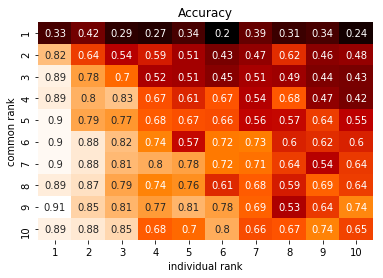

Common rank = 9, Individual rank = 1
Accuracy  Precision  Recall  F1 score
[0.91145833 0.93020833 0.91145833 0.90811012]


In [95]:
result_dirname = '../results/experiment2/'
result_filename = '%s_GLRO_eth80_128.npz' % (method_name)

df = np.load(result_dirname+result_filename)

a = np.mean(df['results'], axis=2)[:, :, 1] # select ica
individualRanks = df['individualRanks']
commonRanks = df['commonRanks']
cmapHot = plt.get_cmap('gist_heat')
ax = sns.heatmap(
    a[:, :, 0], annot=True, cmap=cmapHot, cbar=False,
    xticklabels=individualRanks, yticklabels=commonRanks
)
ax.set_xlabel('individual rank')
ax.set_ylabel('common rank')
plt.title('Accuracy')
plt.show()

ind = np.where(a[:, :, 0] == a[:, :, 0].max())

print "Common rank = %d, Individual rank = %d" % (commonRanks[ind[0][0]], individualRanks[ind[1][0]])
print "Accuracy  Precision  Recall  F1 score"
print a[ind[0][0], ind[1][0], :]

## Group Tucker-(Lr, 1) decomposition (GTLD) <a class="anchor" id="5-gtld"></a>

- [5.1 Initialization](#5-1-init)
- [5.2 Learning](#5-2-learning)
- [5.3 Prediction](#5-3-prediction)
- [5.4 Results](#5-4-results)

[Back to contents](#Contents)

### 5.1 Initialization <a class="anchor" id="5-1-init"></a>

[Up to section](#5-gtld) $\quad$
[Back to contents](#Contents)

In [68]:
shapeGTLD = [Nsamples, Nframes, Npix, Ncolors]
X = reshape(data, shapeGTLD)
transposition = [0, 2, 1, 3]
X = np.transpose(X, transposition)
shapeGTLD = X.shape

individualRanks = 1+np.arange(10)
commonRanks = 1+np.arange(10)
maxitnum = 10
epsilon = 1e-5

method_name = 'als'
constraint_method = 'projected'

sourceModes = [0] # Nsamples are not to be taken into account

random_State = None
model_dirname = '../models/gtld/'

### 5.2 Learning <a class="anchor" id="5-2-learning"></a>

[Up to section](#5-gtld) $\quad$
[Back to contents](#Contents)

In [ ]:
try:
    os.makedirs(model_dirname)
except:
    print 'Already exist: %s' % (model_dirname)

# estimate parameters
for k_comr in xrange(len(commonRanks)):
    commonRank = [commonRanks[k_comr]] + list(shapeGTLD[2:])
    print "Ranks %s (%3.2f%%)" % (str(commonRank), float(k_comr+1)/len(commonRanks) * 100.)
    for k_indr in xrange(len(individualRanks)):
        individualRank = individualRanks[k_indr]
        print "\t Rank %d (%3.2f%%)" % (individualRank, float(k_indr+1)/len(individualRanks) * 100.)
        for k_trial in xrange(len(train_indices)):
            train_index = train_indices[k_trial]
            classifier = GTLDClassifier(
                individualRank, commonRank, shapeGTLD[1:], sourceModes, method=method_name, nShortModes=None,
                constraintMethod=constraint_method, fullModesConstraint=None, maxitnum=maxitnum,
                epsilon=epsilon
            )
            
            classifier.fit(X[train_index], y[train_index], verbose=1)
            save_filename_base = 'GTLD_crank=%d_irank=%d_%d' % (commonRank, individualRank, j)
            classifier.saveParameters(model_dirname+'unconstrained_'+save_filename_base)
            classifier.transformSources('ica', random_state, maxitnum)
            classifier.saveParameters(model_dirname+'ica_'+save_filename_base)
            print "\t\t Index %d / %d" % (k_trial+1, len(train_indices))

### 5.3 Prediction <a class="anchor" id="5-3-prediction"></a>

[Up to section](#5-gtld) $\quad$
[Back to contents](#Contents)

In [ ]:
method_name = 'als'
# method_name = 'dogleg'
# method_name = 'scg-fn'
constraint_method = 'projected'
#constraint_method = 'lm'

prefixes = ['ica', 'unconstrained']

results = np.zeros([len(commonRanks), len(individualRanks), n_splits, len(prefixes), len(metrics)])

model_dirname = '../models/gtld/'
save_dirname = '../results/experiment2/'
try:
    os.makedirs(save_dirname)
except:
    print 'Already exist: %s' % (save_dirname)
for k_prefix in xrange(len(prefixes)):
    prefix = prefixes[k_prefix]
    print prefix
    for k_comr in xrange(len(commonRanks)):
        commonRank = commonRanks[k_comr]
        print "Rank %d (%3.2f%%)" % (commonRank, float(k_comr+1)/len(commonRanks) * 100.)
        for k_indr in xrange(len(individualRanks)):
            individualRank = individualRanks[k_indr]
            print "\t Rank %d (%3.2f%%)" % (individualRank, float(k_indr+1)/len(individualRanks) * 100.)
            for k_trial in xrange(n_splits):
                model_filename_base = 'GTLD_crank=%d_irank=%d_%d' % (commonRank, individualRank, k_trial)
                classifier = GTLDClassifier(
                    individualRank, commonRank, shapeGTLD[1:], sourceModes,
                    method=method_name, nShortModes=None,
                    constraintMethod=constraint_method, fullModesConstraint=None
                )
                classifier.loadParameters(model_dirname+prefix+'_'+model_filename_base+'.npz')
                y_true = y[test_indices[k_trial]]

                y_pred = classifier.predict(
                    X[test_indices[k_trial]],
                    reproject=0,
                )
                for k_metric in xrange(len(metrics)):
                    results[k_comr, k_indr, k_trial, k_prefix, k_metric] = metrics[k_metric](y_true, y_pred)
                np.savez_compressed(
                    save_dirname+method_name+'_GTLD_eth80_128_0',
                    results=results, method_name=method_name,
                    prefixes=prefixes, commonRanks=commonRanks,
                    individualRanks=individualRanks, n_splits=n_splits,
                )

### 5.4 Results <a class="anchor" id="5-4-results"></a>

[Up to section](#5-gtld) $\quad$
[Back to contents](#Contents)

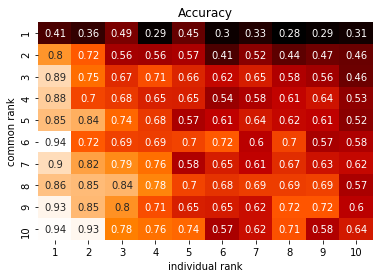

Common rank = 6, Individual rank = 1
Accuracy  Precision  Recall  F1 score
[0.94270833 0.953125   0.94270833 0.94107143]


In [92]:
result_dirname = '../results/experiment2/'
result_filename = '%s_GTLD_eth80_128.npz' % (method_name)

df = np.load(result_dirname+result_filename)

a = np.mean(df['results'], axis=2)[:, :, 0]
individualRanks = df['individualRanks']
commonRanks = df['commonRanks']
cmapHot = plt.get_cmap('gist_heat')
ax = sns.heatmap(
    a[:, :, 0], annot=True, cmap=cmapHot, cbar=False,
    xticklabels=individualRanks, yticklabels=commonRanks
)
ax.set_xlabel('individual rank')
ax.set_ylabel('common rank')
plt.title('Accuracy')
plt.show()

ind = np.where(a[:, :, 0] == a[:, :, 0].max())

print "Common rank = %d, Individual rank = %d" % (commonRanks[ind[0][0]], individualRanks[ind[1][0]])
print "Accuracy  Precision  Recall  F1 score"
print a[ind[0][0], ind[1][0], :]